<img src="https://thevalley.es/wp-content/uploads/2016/11/thevalley-logo-negro.png" width="400"></img>

# Proceso sobre las imágenes del catastro italiano para eliminar la marca de agua

Esta libreta tiene un proceso que elimina la marca de agua del catastro Italiano usando un algoritmo basado en KNN, parte del supuesto de:

* La marca de agua está en tono rojo
* Cada capa tiene un color de fondo distinto

__Author__: David Rey

Trabajaremos con datos de parcelas o edificios catastrales de Italia, ejemplo:

<img src="https://github.com/davidreyblanco/ml-training/blob/master/data/raster/sample-part.png?raw=true" width="400"></img>

El objetivo es disponer de un sistema que de forma automática elimine la marca de agua:

<img src="https://github.com/davidreyblanco/ml-training/blob/master/resources/example-clean.png?raw=true" width="500"></img>

Nuestro objetivo será eliminar ciertos patrones en la imagen y sustituirlos por los colores del fondo, para ello usaremos _información local_ de cada pixel:

<img src="https://github.com/davidreyblanco/ml-training/blob/master/resources/knn-grid.png?raw=true" width="200"></img>




## Carga de la imagen

Cargamos los datos de la imagen desde una URL

In [ ]:
#
# Cargamos la imagen
#

from PIL import Image
from PIL import ImageFilter
import matplotlib.pyplot as plt
import numpy as np
import os
import requests

#
# Crea directorio de trabajo
#
if not os.path.exists('data'):
    os.makedirs('data')

#mode = 'building'
mode = 'parcel'
f_in = 'https://github.com/davidreyblanco/ml-training/raw/master/data/raster/sample-part.png'


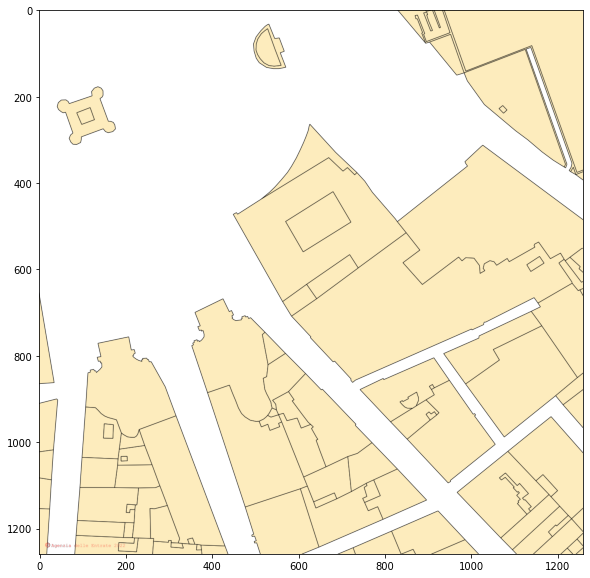

In [ ]:
# Cargamos desde una URL

im = Image.open(requests.get(f_in, stream=True).raw)
data_input = np.array(im)   # "data" is a height x width x 4 numpy array

#
# Mostramos la imagen
#
plt.figure(figsize=(10, 10))  # 2 row and 1 column.
plt.subplots_adjust(hspace=1)  # or you can try: plt.tight_layout()
plt.imshow(im)
plt.show()


### Recortamos la imagen

Vamos a quedarnos con la parte de la imagen dónde está la marca de agua (parte superior izquierda), Suponemos que es el 3% inferior y el 17% de ancho de la imagen.

In [ ]:
#
# Seleccionamos una zona de trabajo donde se encuentra la marca de agua (abajo a la izquierda)
#

height = len(data_input)
width = len(data_input[0])

j_range = (round(width * 0.97), height - 10)
i_range = (0, round(width * 0.17))

print((j_range,i_range))

((1221, 1249), (0, 214))


## Funciones útiles

Definimos una serie de funciones de utilidad para el trabajo con colores:

* Similitud coseno (en componentes de colores), en realidad nos interesa esta medida porque cambios en intensidad de color se refieren al mismo como y cambios en la composición del componente (ángulo) se refieren a colores distintos.
* Distintas funciones que devuelven el tipo de color que es (sando distancia/similitud coseno).
*

In [ ]:
import math

#
# Creamos una medida de similitud de las componentes de color usando la distancia coseno,
# definimos además una serie de funciones básicas sobre colores comunes
#
def color_cosine_similarity(col_1, col_2):
    if col_1[0] == col_2[0] and  col_1[1] == col_2[1] and  col_1[2] == col_2[2]:
        dist = 0
    else:
        a = col_1[0] * col_2[0] + col_1[1] * col_2[1] + col_1[2] * col_2[2]
        b_1 = math.sqrt(col_1[0]**2 + col_1[1]**2 + col_1[2]**2)
        b_2 = math.sqrt(col_2[0]**2 + col_2[1]**2 + col_2[2]**2)
        b = b_1 * b_2 + 0.001
        dist = a / b
    return dist

def is_red(color):
    red_color = (255, 0, 0)
    dist = color_cosine_similarity(color, red_color)
    return dist

def is_black(color):
    black_color = (0, 0, 0)
    dist = color_cosine_similarity(color, black_color)
    return dist

def is_white(color):
    white_color = (255, 255, 255)
    dist = color_cosine_similarity(color, white_color)
    return dist

#
# Devuelve el nivel medio de color de las 3 componentes
#
def get_average_color(color):
    dist = (color[0] + color[1] + color[2])/3
    return dist

#
# Definición de ciertas constantes
#
black_color = (0, 0, 0)
white_color = (255, 255, 255)
red_color = (255, 0, 0)
c1 = (100,100,0)
c2 = (255,255,0)
c1 = (100,2,3)

print('Algunos ejemplos')
print(color_cosine_similarity(c1, red_color))
print(is_red(c1))
print(is_red(c2))
print(is_black(c1))
print(get_average_color(data_input[10][10]) > 20)

0.999350593899447
0.999350593899447
0.7071067734971973
0.0
False


## Parámetros

In [ ]:
#
# Establecemos unos parámetros para cada capa en función del color
#
color_background = (0, 0, 0, 0)
color_polygon = (252,236,189, 255) # Particella -> amarillo
threshold_background = 0.2
threshold_line = 0.5
threshold_red = 0.65
threshold_black = 0.85
n_neighbors = 5
min_red_level = 10

## Eliminación de marca de agua e imputacion por kNN

In [ ]:
#
# Extraemos una matriz de colores original y de trabajo
#
data_input_processed = np.array(im)   # Copiamos el dato de entrada (cada celda tiene cuatro compoenentes - color + alpha)

#
# Procesamos cada pixel de nuestra área de trabajo (la parte inferior izquierda)
#
# Hay dos colores especiales :
#
#     * vacío o transparente
#     * borde o color negro
#
for j in range(j_range[0], j_range[1]):
    for i in range(i_range[0], i_range[1]):
        base_item = data_input[j][i]
        #
        # Condiciones de proceso del pixel:
        #
        #     1) No debe ser transparente
        #     2) Debe tener un mínimo nivel de rojo (componente)
        #     3) Debe tener un mínimo nivel de rojo (similitud coseno)
        #     4) No debe ser negro (dis-similitud coseno)
        #
        if base_item[3] != 0 \
            and base_item[0] >= min_red_level \
            and is_red(base_item) > threshold_red \
            and is_black(base_item) <= threshold_black:

            #
            #     Creamos conteos ponderados inversamente proporcionales a la distancia
            #
            n_border = 0
            n_background = 0
            n_other = 0
            n_total = 0
            color_r, color_g, color_b = 0, 0, 0

            #
            # Seleccionamos n_neighbors² celdas para hacer una votación de color
            #  ponderada inversamente proporcional a la distancia
            #
            for dx in range(-n_neighbors, n_neighbors):
                for dy in range(-n_neighbors, n_neighbors):

                    #
                    #  Cada pixel será inversamente proporcional a la distancia
                    #
                    if dx == 0 and dy == 0:
                        weight = 1 # Evitar división por cero
                    else:
                        #
                        # inverso de la distancia euclidea
                        # usamos el cuadrado para penalizar las mayores distancias
                        #
                        weight = 1 / (math.sqrt(dx**2 + dy**2))**2

                    item = data_input[j + dy][i + dx]

                    if item[3] == 0: # El vecino transparent
                        n_background += weight
                    elif is_black(item) > 0.9 : # is black
                        n_border += weight
                    else:
                        n_other += weight       # En otros casos
                    n_total += weight

            #
            # Reasignamos los colores (transparente, negro o color original)
            #
            if n_border / n_total > threshold_line:
                data_input_processed[j][i] = color_black
            elif n_background / n_total > threshold_background:
                data_input_processed[j][i] = color_background
            else:
                #data_input[j][i] = color_polygon #color_polygon
                data_input_processed[j][i] = color_polygon
                #data_input_processed[j][i] = color_black


#
# Construimos la nueva imagen generada
#
im2 = Image.fromarray(data_input_processed)
f_out = "./data/out_" + mode + ".png"
im2.save(f_out, "PNG")


## Resultados

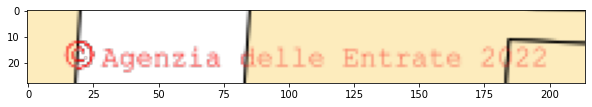

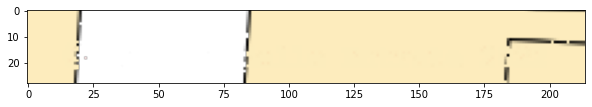

In [ ]:
#
# Mostramos la imagen original (cortada)
#
cropped_image = im.crop((i_range[0], j_range[0],  i_range[1],  j_range[1]))
plt.figure(figsize=(10, 10))  # 2 row and 1 column.
plt.subplots_adjust(hspace=1)  # or you can try: plt.tight_layout()
plt.imshow(cropped_image)
plt.show()

#
# Mostramos la imagen original (procesada)
#
cropped_image = im2.crop((i_range[0], j_range[0],  i_range[1],  j_range[1]))
plt.figure(figsize=(10, 10))  # 2 row and 1 column.
plt.subplots_adjust(hspace=1)  # or you can try: plt.tight_layout()
plt.imshow(cropped_image)
plt.show()

__Preguntas__:

* ¿Qué pasa si eliminamos vecinos?, en los bordes y en las áreas rellenas y vacío.
* ¿Qué ganamos añadiendo vecinos en los casos anteriores?